COSMOS is a deep, wide area, multi-wavelength survey aimed at measuring the evolution of galaxies on scales from a few Kpc to 10's of Mpc.

The COSMOS survey is centered at (J2000):
RA +150.11916667 (10:00:28.600)
DEC +2.20583333 (+02:12:21.00)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import imaginglss
decals = imaginglss.DECALS('/project/projectdirs/m779/imaginglss/dr2.conf.py')

In [3]:
import h5py

In [4]:
dr = decals.datarelease

In [5]:
RA = 340
DEC = 0
stripe82 = dr.create_footprint((320, 359.99, DEC-1.25, DEC+1.25 ))

In [6]:
stripe82_DR2 = stripe82.intersect(dr.footprint)

cat = dr.create_catalogue(stripe82_DR2)
f = h5py.File('stripe82-DR2.hdf5')
ds = f.create_dataset("Objects", data=cat)
f.close()
del ds
del f

In [7]:
f = h5py.File('stripe82-DR2.hdf5')
cat = f['Objects'][:]

In [69]:
!rm '/project/projectdirs/m779/yfeng1/imaginglss/stripe82-DR2.fits'
f = fitsio.FITS('/project/projectdirs/m779/yfeng1/imaginglss/stripe82-DR2.fits', 'rw')
f.write(cat)

In [70]:
f = h5py.File('/project/projectdirs/m779/yfeng1/imaginglss/stripe82-DR2.hdf5')
ds = f.create_dataset("Objects", data=cat)
f.close()

In [60]:
f = fitsio.FITS('/project/projectdirs/m779/yfeng1/imaginglss/stripe82-DR2.fits', 'rw')
print f[2][:]

[]


In [8]:
from imaginglss.model.columnnames import *

198302


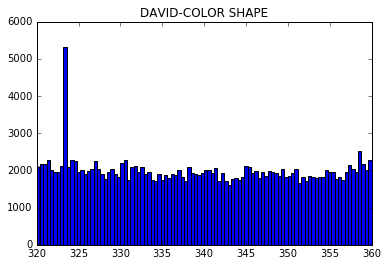

In [130]:
def scope():
    QSO = BRICK_PRIMARY != 0
    QSO &= Max(SHAPEEXP_R,SHAPEDEV_R) < 0.5
    #QSO &= TYPE == 'PSF '
    QSO &= RFLUX > 10**((22.5-23.0)/2.5)
    QSO &= RFLUX < 10**(1.0/2.5) * GFLUX
    QSO &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSO &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSO &= WFLUX * GFLUX ** 1.2 > 10**(-.4/2.5) * RFLUX ** (1+1.2)
    QSO &= DECAM_ANYMASK[1] == 0
    QSO &= DECAM_ANYMASK[2] == 0
    QSO &= DECAM_ANYMASK[4] == 0
    return QSO
QSO = scope()
data = QSO(cat)['RA']
print len(data)
_ = hist(data, range=(320, 360), bins=100, weights=ones(len(data)) / (2.5 * 0.4))
title("DAVID-COLOR SHAPE")

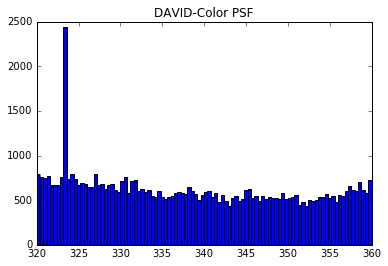

In [129]:
def scope():
    QSO = BRICK_PRIMARY != 0
    QSO &= TYPE == 'PSF '
    QSO &= RFLUX > 10**((22.5-23.0)/2.5)
    QSO &= RFLUX < 10**(1.0/2.5) * GFLUX
    QSO &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSO &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSO &= WFLUX * GFLUX ** 1.2 > 10**(-.4/2.5) * RFLUX ** (1+1.2)
    QSO &= DECAM_ANYMASK[1] == 0
    QSO &= DECAM_ANYMASK[2] == 0
    QSO &= DECAM_ANYMASK[4] == 0
    return QSO
QSO = scope()
data = QSO(cat)['RA']
_ = hist(data, range=(320, 360), bins=100, weights=ones(len(data)) / (2.5 * 0.4))
title("DAVID-Color PSF")

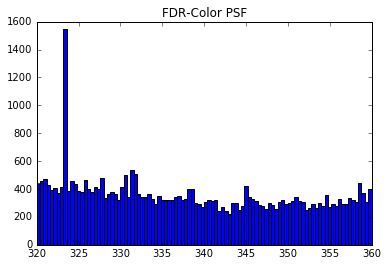

In [49]:
def scope():
    QSOC  = RFLUX > 10**((22.5-23.0)/2.5)
    QSOC &= GRZFLUX < 10**((22.5-17.0)/2.5)
    QSOC &= RFLUX < 10**(1.3/2.5) * GFLUX
    QSOC &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSOC &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSOC &= WFLUX * GFLUX > 10**(-1.0/2.5) * ZFLUX * GRZFLUX
    QSOC &= W2FLUX > W1FLUX * 10**(-0.4 / 2.5)
    QSOC &= SNRW1 > 4
    QSOC &= SNRW2 > 2

    QSO = BRICK_PRIMARY != 0
    QSO &= QSOC
    QSO &= TYPE == 'PSF '
    return QSO
QSO = scope()
data = QSO(cat)['RA']
_ = hist(data, range=(320, 360), bins=100, weights=ones(len(data)) / (2.5 * 0.4))
title("FDR-Color PSF")

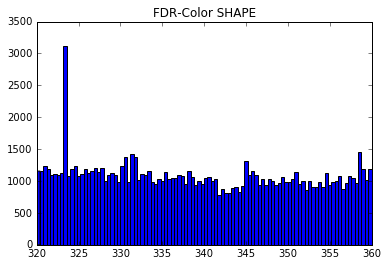

In [50]:
def scope():
    QSOC  = RFLUX > 10**((22.5-23.0)/2.5)
    QSOC &= GRZFLUX < 10**((22.5-17.0)/2.5)
    QSOC &= RFLUX < 10**(1.3/2.5) * GFLUX
    QSOC &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSOC &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSOC &= WFLUX * GFLUX > 10**(-1.0/2.5) * ZFLUX * GRZFLUX
    QSOC &= W2FLUX > W1FLUX * 10**(-0.4 / 2.5)
    QSOC &= SNRW1 > 4
    QSOC &= SNRW2 > 2

    QSO = BRICK_PRIMARY != 0
    QSO &= QSOC
    QSO &= Max(SHAPEEXP_R,SHAPEDEV_R) < 0.5
    return QSO

QSO = scope()
data = QSO(cat)['RA']
_ = hist(data, range=(320, 360), bins=100, weights=ones(len(data)) / (2.5 * 0.4))
title("FDR-Color SHAPE")

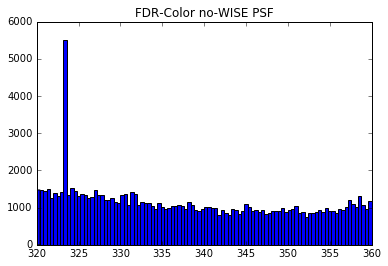

In [51]:
def scope():
    QSOC  = RFLUX > 10**((22.5-23.0)/2.5)
    QSOC &= GRZFLUX < 10**((22.5-17.0)/2.5)
    QSOC &= RFLUX < 10**(1.3/2.5) * GFLUX
    QSOC &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSOC &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSOC &= WFLUX * GFLUX > 10**(-1.0/2.5) * ZFLUX * GRZFLUX
#    QSOC &= W2FLUX > W1FLUX * 10**(-0.4 / 2.5)
#    QSOC &= SNRW1 > 4
#    QSOC &= SNRW2 > 2

    QSO = BRICK_PRIMARY != 0
    QSO &= QSOC
#    QSO &= Max(SHAPEEXP_R,SHAPEDEV_R) < 0.5
    QSO &= TYPE == 'PSF '
    return QSO

QSO = scope()
data = QSO(cat)['RA']
_ = hist(data, range=(320, 360), bins=100, weights=ones(len(data)) / (2.5 * 0.4))
title("FDR-Color no-WISE PSF")

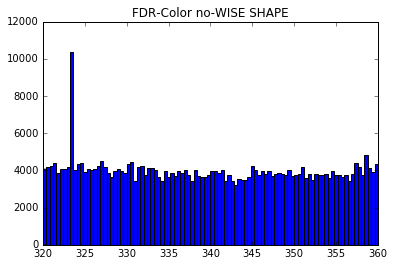

In [52]:
def scope():
    QSOC  = RFLUX > 10**((22.5-23.0)/2.5)
    QSOC &= GRZFLUX < 10**((22.5-17.0)/2.5)
    QSOC &= RFLUX < 10**(1.3/2.5) * GFLUX
    QSOC &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSOC &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSOC &= WFLUX * GFLUX > 10**(-1.0/2.5) * ZFLUX * GRZFLUX
#    QSOC &= W2FLUX > W1FLUX * 10**(-0.4 / 2.5)
#    QSOC &= SNRW1 > 4
#    QSOC &= SNRW2 > 2

    QSO = BRICK_PRIMARY != 0
    QSO &= QSOC
    QSO &= Max(SHAPEEXP_R,SHAPEDEV_R) < 0.5
#    QSO &= TYPE == 'PSF '
    return QSO

QSO = scope()
data = QSO(cat)['RA']
_ = hist(data, range=(320, 360), bins=100, weights=ones(len(data)) / (2.5 * 0.4))
title("FDR-Color no-WISE SHAPE")

In [38]:
fdr_nopsf = QSO_fdr_nopsf(cat)

In [28]:
david_mine = QSO_david(cat)

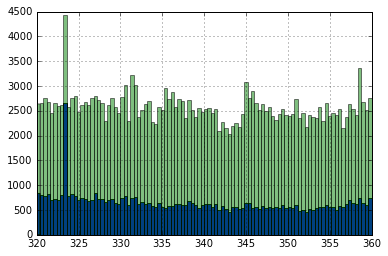

In [39]:
_ = hist(david_mine['RA'], range=(320, 360), bins=100, weights=ones(len(david_mine)) / (2.5 * 0.4))
_ = hist(fdr_nopsf['RA'], range=(320, 360), bins=100, weights=ones(len(fdr_nopsf)) / (2.5 * 0.4), alpha=0.5)
grid()
#_ = hist(david['RA'], range=(320, 360), bins=100)

In [76]:
import fitsio
david =  fitsio.FITS('/global/project/projectdirs/desi/target/stripe82-dr2/targets-QSO.fits', )[1][:]

In [ ]:
print QSO_david[5]

In [114]:
def scope():
    QSO = BRICK_PRIMARY != 0
    QSO &= Max(SHAPEEXP_R,SHAPEDEV_R) < 0.5
    #QSO &= TYPE == 'PSF '
    QSO &= RFLUX > 10**((22.5-23.0)/2.5)
    QSO &= RFLUX < 10**(1.0/2.5) * GFLUX
    QSO &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSO &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSO &= WFLUX * GFLUX ** 1.2 > 10**(-0.4 /2.5) * RFLUX ** (1+1.2)
    QSO &= DECAM_ANYMASK[1] == 0
    QSO &= DECAM_ANYMASK[2] == 0
    QSO &= DECAM_ANYMASK[4] == 0
    return QSO
QSO_david = scope()


In [115]:
print QSO_david[5](david).shape

(134102,)


[]

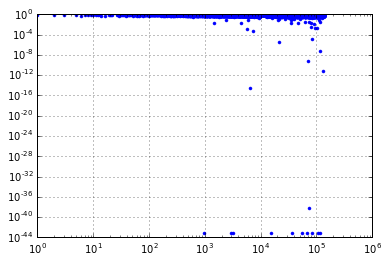

In [119]:
left = QSO_david[1][0].apply(david)
right = QSO_david[1][1].apply(david)
plot(left / right, '. ')
grid()
loglog()


In [16]:
print QSO_david.apply(david).all()

True


In [69]:
print david['SHAPEEXP_R'].min()

0.0


In [32]:
mask = QSO.apply(cat)

In [36]:
mask &= abs(cat['DEC']) < 1.0

In [37]:
print mask.sum()


26426


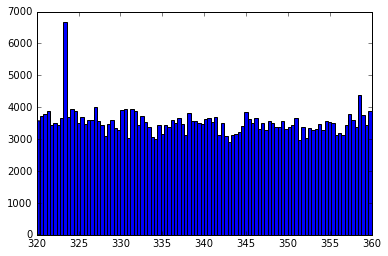

In [44]:
_ = hist(cat['RA'][mask_david], bins=100, range=(320, 360))

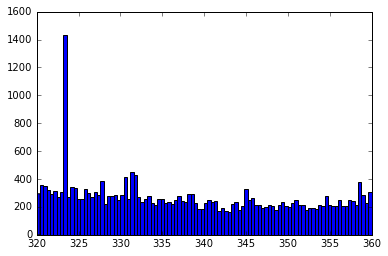

In [83]:
_ = hist(cat['RA'][mask], bins=100, range=(320, 360))

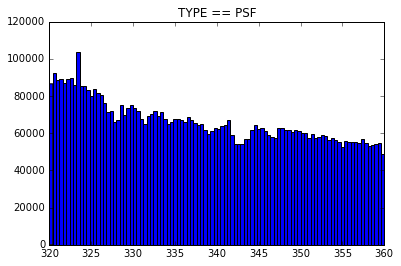

In [75]:
PSFMASK = cat['TYPE'] == 'PSF '
_ = hist(cat['RA'][PSFMASK], bins=100, range=(320, 360), weights=ones(PSFMASK.sum()) / (2.5 * 0.4))
title("TYPE == PSF")